In [27]:
!pip install python-dateutil


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip


## Approach

1. Train an LSTM model for 10 epochs
2. Tran a prophet model
3. Use the results from prophet model as a trend smoothen factor (i.e. heuristic or bias reducer) for the result of LSTM model

In [476]:
import pandas as pd
import os
import datetime as dt
from datetime import datetime, timedelta
import numpy as np
from dateutil.relativedelta import *

import math
import matplotlib.pyplot as plt

In [477]:
# For Evalution we will use these library

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler


In [63]:
# For PLotting we will use these library

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [478]:
# get the data
url = 'https://cexa.oceanprotocol.io/ohlc?exchange=binance&pair=ETH/USDT&period=1h'
df = pd.read_json(url)

In [253]:
df.tail()

,0,1,2,3,4,5
995,1676826000000,1698.81,1702.50,1675.96,1682.56,42096.1020
996,1676829600000,1682.56,1688.10,1678.24,1685.62,14802.5562
997,1676833200000,1685.63,1690.13,1683.49,1684.80,11298.9282
998,1676836800000,1684.80,1687.81,1666.14,1686.97,28031.4114
999,1676840400000,1686.98,1687.14,1682.07,1684.01,10118.8002


(1000, 5)


,open,high,low,close,volume
dt1,,,,,
2023-02-19 21:00:00,1686.98,1687.14,1682.07,1685.97,12684.4748
2023-02-19 22:00:00,1685.97,1688.85,1681.75,1685.55,7566.9437
2023-02-19 23:00:00,1685.54,1685.55,1680.19,1683.58,3143.3014


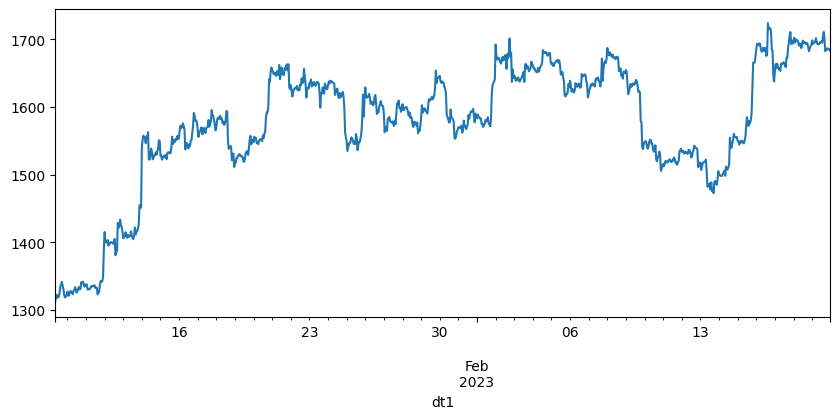

In [479]:
data_dir = 'data'
df.columns = ['dt1','open','high','low','close','volume']
# convert to UTC+0
a = [datetime.fromtimestamp(x/1000) - relativedelta(hours=8) for x in df.dt1]
df['dt1'] = a
os.makedirs(data_dir, exist_ok=True)
df.to_csv(f'{data_dir}/ETH_USDT_new.csv', index = False)
df.set_index('dt1', inplace = True)

print(df.shape)
display(df[-3:])

_ = df['close'].plot(figsize = (10,4))

07:07:44 - cmdstanpy - INFO - Chain [1] start processing
07:07:44 - cmdstanpy - INFO - Chain [1] done processing


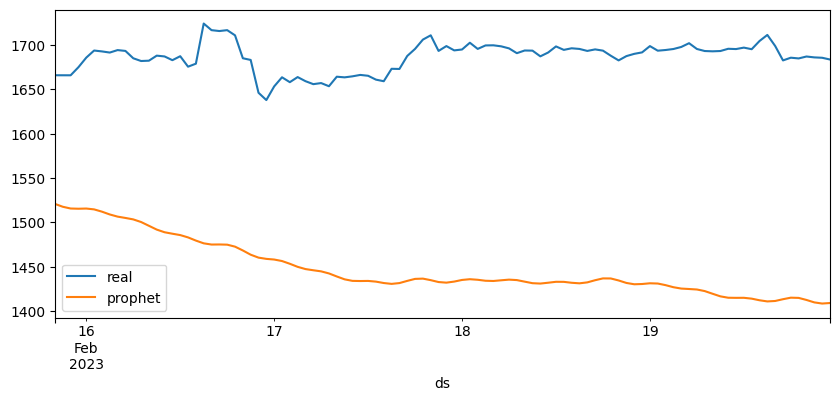

In [481]:
from prophet import Prophet

t1 = 100
# 1) prepare dataframe
train_x = df.close.iloc[:-t1]
test_x = df.close.iloc[-t1:]
x = train_x
x = x.reset_index()
x.columns = ['ds','y']
test_x = test_x.reset_index()
test_x.columns = ['ds','y']

# 2) build model
m = Prophet(weekly_seasonality=True, daily_seasonality=True, )
m.fit(x)

# # 3) predict
df1 = m.make_future_dataframe(periods=t1, freq='h')
df_out = m.predict(df1).iloc[-t1:]

# 4) plotting
_ = test_x.set_index('ds').plot(figsize = (10,4))
_ = df_out.set_index('ds')['yhat'].plot()
_ = _.legend(['real','prophet'])

In [256]:
df_out.tail(30)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
970,2023-02-18 16:00:00,1625.419507,1598.163510,1682.529634,1601.547485,1649.227352,13.291750,13.291750,13.291750,-2.431161,-2.431161,-2.431161,15.722911,15.722911,15.722911,0.0,0.0,0.0,1638.711257
971,2023-02-18 17:00:00,1625.908226,1600.029964,1685.053123,1600.783111,1651.114377,15.439995,15.439995,15.439995,-0.024801,-0.024801,-0.024801,15.464796,15.464796,15.464796,0.0,0.0,0.0,1641.348221
972,2023-02-18 18:00:00,1626.396946,1598.931645,1687.732331,1600.270418,1652.515367,17.546653,17.546653,17.546653,2.475855,2.475855,2.475855,15.070798,15.070798,15.070798,0.0,0.0,0.0,1643.943599
973,2023-02-18 19:00:00,1626.885665,1599.660947,1690.680844,1599.629655,1653.875623,18.051489,18.051489,18.051489,3.513773,3.513773,3.513773,14.537716,14.537716,14.537716,0.0,0.0,0.0,1644.937154
974,2023-02-18 20:00:00,1627.374384,1599.074784,1690.080904,1597.342324,1655.763089,16.524254,16.524254,16.524254,2.660292,2.660292,2.660292,13.863962,13.863962,13.863962,0.0,0.0,0.0,1643.898638
975,2023-02-18 21:00:00,1627.863103,1596.582718,1689.756377,1595.976019,1657.133467,14.056173,14.056173,14.056173,1.006608,1.006608,1.006608,13.049565,13.049565,13.049565,0.0,0.0,0.0,1641.919276
976,2023-02-18 22:00:00,1628.351822,1594.716672,1689.859455,1594.854537,1658.274512,12.268900,12.268900,12.268900,0.172741,0.172741,0.172741,12.096159,12.096159,12.096159,0.0,0.0,0.0,1640.620722
977,2023-02-18 23:00:00,1628.840542,1594.912691,1691.118741,1593.697968,1661.201606,11.876724,11.876724,11.876724,0.869777,0.869777,0.869777,11.006947,11.006947,11.006947,0.0,0.0,0.0,1640.717266
978,2023-02-19 00:00:00,1629.329261,1595.028972,1696.544118,1592.238863,1663.492122,12.147349,12.147349,12.147349,2.360696,2.360696,2.360696,9.786654,9.786654,9.786654,0.0,0.0,0.0,1641.476610
979,2023-02-19 01:00:00,1629.817980,1589.513404,1692.544046,1591.396038,1664.859490,11.717141,11.717141,11.717141,3.275692,3.275692,3.275692,8.441449,8.441449,8.441449,0.0,0.0,0.0,1641.535121


In [482]:
from sklearn import metrics
# evaluation metrics
def ts_metrics(y_true, y_pred):
    return {
        'mae': metrics.mean_absolute_error(y_true, y_pred),
        'mse': metrics.mean_squared_error(y_true, y_pred),
        'mape': np.mean(np.abs((y_true - y_pred) / y_true)),
        'smape': np.mean(np.abs( 2*(y_true - y_pred) / (y_true+np.abs(y_pred)))),
        'nmse':  np.sum((y_true - y_pred)**2) / np.sum((y_true)**2),
    }

In [483]:

# results
# df_out = pd.DataFrame()
prophet_metrics = ts_metrics(test_x['y'], df_out['yhat'])
prophet_metrics

{'mae': 239.08364543321852,
 'mse': 58537.48246035246,
 'mape': nan,
 'smape': nan,
 'nmse': 0.0}

### LSTM

In [187]:
# For model building we will use these library

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

In [188]:
df.tail()

,open,high,low,close,volume
dt1,,,,,
2023-02-19 16:00:00,1711.30,1726.59,1690.00,1698.82,48125.0928
2023-02-19 17:00:00,1698.81,1702.50,1675.96,1682.56,42096.1020
2023-02-19 18:00:00,1682.56,1688.10,1678.24,1685.62,14802.5562
2023-02-19 19:00:00,1685.63,1690.13,1683.49,1684.80,11298.9282
2023-02-19 20:00:00,1684.80,1684.80,1666.14,1677.06,19246.9915


In [486]:
close_df = df[['close']]
close_stock = close_df.copy()

In [487]:
scaler=MinMaxScaler(feature_range=(0,1))
close_df=scaler.fit_transform(np.array(close_df).reshape(-1,1))

In [413]:
# we keep the training set as 60%, 30% for validation and 10% testing set

training_size=int(len(close_df)*0.60)
validation_size = int(len(close_df)*0.30)
test_size=len(close_df)-training_size -  validation_size
train_data=close_df[0:training_size,:]
validation_data = close_df[training_size:training_size + validation_size,:1]
test_data = close_df[training_size + validation_size:len(close_df),:1]
print("train_data: ", train_data.shape)
print("validation_data: ", validation_data.shape)
print("test_data: ", test_data.shape)

train_data:  (600, 1)
validation_data:  (300, 1)
test_data:  (100, 1)


In [414]:


# convert an array of values into a dataset matrix

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)



In [415]:


time_step = 12 * 2#12#15
X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(validation_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)



X_train:  (575, 24)
y_train:  (575,)
X_val:  (275, 24)
y_val:  (275,)
X_test:  (75, 24)
y_test (75,)


In [416]:
model=Sequential()

unit_cnt = 20
# 10, 15, 20
model.add(LSTM(unit_cnt,input_shape=(None,1),activation="relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")

In [417]:
history = model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=int(unit_cnt * 4),batch_size=32,verbose=1)

Epoch 1/80
18/18 [==============================] - 1s 10ms/step - loss: 0.3044 - val_loss: 0.2757
Epoch 2/80
18/18 [==============================] - 0s 7ms/step - loss: 0.1692 - val_loss: 0.0974
Epoch 3/80
18/18 [==============================] - 0s 7ms/step - loss: 0.0296 - val_loss: 0.0099
Epoch 4/80
18/18 [==============================] - 0s 9ms/step - loss: 0.0072 - val_loss: 0.0022
Epoch 5/80
18/18 [==============================] - 0s 6ms/step - loss: 0.0050 - val_loss: 0.0019
Epoch 6/80
18/18 [==============================] - 0s 5ms/step - loss: 0.0047 - val_loss: 0.0022
Epoch 7/80
18/18 [==============================] - 0s 4ms/step - loss: 0.0045 - val_loss: 0.0024
Epoch 8/80
18/18 [==============================] - 0s 8ms/step - loss: 0.0043 - val_loss: 0.0021
Epoch 9/80
18/18 [==============================] - 0s 10ms/step - loss: 0.0036 - val_loss: 0.0023
Epoch 10/80
18/18 [==============================] - 0s 7ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 11/80
18/18

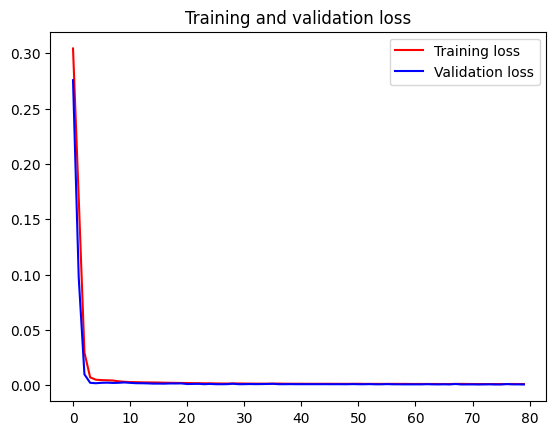

<Figure size 640x480 with 0 Axes>

In [418]:

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [419]:


### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
val_predict=model.predict(X_val)
test_predict=model.predict(X_test)
train_predict.shape, val_predict.shape, test_predict.shape



3/3 [==============================] - 0s 1ms/step


((575, 1), (275, 1), (75, 1))

In [420]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
val_predict = scaler.inverse_transform(val_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 


In [421]:


# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))



Train data RMSE:  13.43810592931264
Train data MSE:  180.58269096742754
Train data MAE:  8.820438510529888
-------------------------------------------------------------------------------------
Test data RMSE:  11.750340618620385
Test data MSE:  138.0705046536001
Test data MAE:  7.547243815104139


In [422]:


print("Train data explained variance regression score:", 
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", 
      explained_variance_score(original_ytest, test_predict))



Train data explained variance regression score: 0.9766941233623341
Test data explained variance regression score: 0.5224568683762683


In [423]:


print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))



Train data R2 score: 0.9766785064599084
Test data R2 score: 0.522341467631827


In [424]:


print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))



Train data MGD:  7.628249380851377e-05
Test data MGD:  4.879797278633191e-05
----------------------------------------------------------------------
Train data MPD:  0.11717259509168244
Test data MPD:  0.08207768887044344


In [425]:


# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(close_df)
trainPredictPlot[:, :] = np.nan
start = look_back
end = len(train_predict)+look_back
print(f"start: {start}")
print(f"end: {end}")
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift validation predictions for plotting
valPredictPlot = np.empty_like(close_df)
valPredictPlot[:, :] = np.nan
start = len(train_predict)+(look_back * 2) + 1
end = len(val_predict) + start
# start += 1
print(f"start: {start}")
print(f"end: {end}")
valPredictPlot[start:end, :] = val_predict
print("Val predicted data: ", valPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(close_df)
testPredictPlot[:, :] = np.nan
start = len(train_predict) + len(val_predict) + (look_back*3) + 2
end = len(test_predict) + start
print(f"start: {start}")
print(f"end: {end}")
testPredictPlot[start:len(close_df)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Valid predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock.index,
                       'original_close': close_stock['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'valid_predicted_close': valPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['valid_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Eth price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()



start: 24
end: 599
Train predicted data:  (1000, 1)
start: 624
end: 899
Val predicted data:  (1000, 1)
start: 924
end: 999
Test predicted data:  (1000, 1)


### LSTM is surprisingly good at memorising even the seemingly stochastic price movements

But we all know, this is some form of overfitting. But thankfully this is just a 12 hour prediction and there shouldn't be any major news that'll sway this from the pattern. 

Also, market seems to be responding to CPI reports rather well, another reason for no deviance from such trend

Nonetheless, let's find a way to lower the bias.


### Smoothening with prophet

Prophet predictions from experience seem to be more indicative of trend than neural networks in general.

This may help to generalise the LSTM results to a the larger trend.

<!-- There also seem to be evidence of smoothening of  -->

In [488]:
# we keep the training set as 60%, 30% for validation and 10% testing set

training_size=int(len(close_df)*0.60)
test_size=len(close_df)-training_size
train_data=close_df[0:training_size,:]
test_data = close_df[training_size:len(close_df),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (600, 1)
test_data:  (400, 1)


In [489]:


time_step = 12 *  2#15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)



X_train:  (575, 24)
y_train:  (575,)
X_test:  (375, 24)
y_test (375,)


In [490]:
model=Sequential()

unit_cnt = 20
# 10, 15, 20
model.add(LSTM(unit_cnt,input_shape=(None,1),activation="relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")

In [491]:
# Generate result

history = model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=int(unit_cnt * 2),batch_size=32,verbose=1)


Epoch 1/40
18/18 [==============================] - 1s 10ms/step - loss: 0.4008 - val_loss: 0.3735
Epoch 2/40
18/18 [==============================] - 0s 5ms/step - loss: 0.2615 - val_loss: 0.2132
Epoch 3/40
18/18 [==============================] - 0s 10ms/step - loss: 0.0889 - val_loss: 0.1174
Epoch 4/40
18/18 [==============================] - 0s 7ms/step - loss: 0.0160 - val_loss: 0.0065
Epoch 5/40
18/18 [==============================] - 0s 8ms/step - loss: 0.0089 - val_loss: 0.0070
Epoch 6/40
18/18 [==============================] - 0s 7ms/step - loss: 0.0074 - val_loss: 0.0092
Epoch 7/40
18/18 [==============================] - 0s 6ms/step - loss: 0.0066 - val_loss: 0.0043
Epoch 8/40
18/18 [==============================] - 0s 7ms/step - loss: 0.0059 - val_loss: 0.0029
Epoch 9/40
18/18 [==============================] - 0s 5ms/step - loss: 0.0053 - val_loss: 0.0019
Epoch 10/40
18/18 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0017
Epoch 11/40
18/18

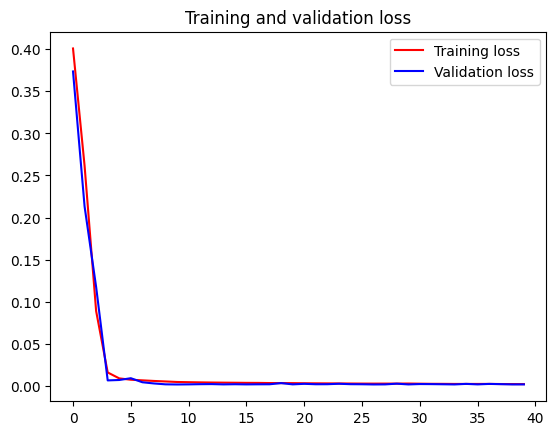

<Figure size 640x480 with 0 Axes>

In [492]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [493]:
test_predict=model.predict(X_test)

12/12 [==============================] - 0s 1ms/step


In [494]:


x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_hours = time_step
while(i<pred_hours):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next hours: ", len(lst_output))



Output of predicted next hours:  24


In [495]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_hours+1)
print(last_days)
print(day_pred)


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
[25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]


In [496]:
temp_mat = np.empty((pred_hours,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat

next_predicted_days_value = temp_mat
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

In [497]:
last_original_days_value[0:time_step+1] = scaler.inverse_transform(close_df[len(close_df)-time_step:]).reshape(1,-1).tolist()[0]

In [498]:
new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price',f'Predicted next {pred_hours} hours close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[
                                                      new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Eth price','index': 'Timestamp'})
fig.update_layout(title_text=f'Next {pred_hours} hours',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()


In [499]:
lst_output

[[0.8253182768821716],
 [0.8098337650299072],
 [0.7966322302818298],
 [0.7834628820419312],
 [0.7706121802330017],
 [0.7583421468734741],
 [0.746996283531189],
 [0.7354090213775635],
 [0.7241075038909912],
 [0.7136192917823792],
 [0.703551173210144],
 [0.6943040490150452],
 [0.6858896017074585],
 [0.6782929301261902],
 [0.6714260578155518],
 [0.6661993861198425],
 [0.6624172925949097],
 [0.6589729189872742],
 [0.6551135182380676],
 [0.6521869897842407],
 [0.650049090385437],
 [0.6482958793640137],
 [0.6473992466926575],
 [0.6472055912017822]]

In [500]:
next_predicted_days_value

[1698.71,
 1693.53,
 1694.2999999999997,
 1695.4199999999998,
 1697.72,
 1701.9799999999998,
 1695.46,
 1693.15,
 1692.82,
 1693.15,
 1695.68,
 1695.3600000000001,
 1696.99,
 1695.1999999999998,
 1704.4400000000003,
 1711.3,
 1698.82,
 1682.5599999999997,
 1685.6200000000001,
 1684.8,
 1686.97,
 1685.97,
 1685.5500000000002,
 1683.58,
 1645.4149820470811,
 1639.9498106920719,
 1634.4979639077187,
 1629.178030372858,
 1624.0984819626808,
 1619.4015214562417,
 1614.6046266698838,
 1609.9260244607926,
 1605.5841144120693,
 1601.4161146855356,
 1597.5879902112486,
 1594.1045773148537,
 1590.9597072136403,
 1588.1169594144822,
 1585.9532218658926,
 1584.3875107884407,
 1582.961609002352,
 1581.3638942801954,
 1580.15237003088,
 1579.2673224377634,
 1578.5415281391145,
 1578.1703401458265,
 1578.090170645714]

In [501]:

from pathlib import Path
def save_list(list_: list, file_name: str):
    """Save a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    p.write_text(str(list_))

In [502]:
toSubmit = next_predicted_days_value[1:13]
len(toSubmit)

12

In [503]:
file_name = "/tmp/pred_vals.csv"
save_list(toSubmit, file_name)